In [1]:
import random, os, sys, re, math, functools, itertools, collections, time, pickle, io
import cv2
sys.path.append('/home/jupyter/Analysis/code')

import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import colors as mcolors
from skimage.filters import threshold_otsu
from PIL import Image, ImageSequence
from sklearn.decomposition import FastICA, PCA
from IPython.display import HTML
from scipy.io import loadmat

import torch
import torch.nn as nn

from utility import densenet_regression, linear_regression, power_series, neighbor_cor, cosine_similarity
from utility import weighted_mse_loss, empty_cache, detect_outliers, svd, get_label_image, read_tiff_file
from visualization import plot_tensor, imshow, plot_cdf, plot_3d_scatter, plot_image, plot_images, plot_curves
from visualization import plot_hist, get_image, make_video, make_3d_video, plot_trace, plot_image_label_overlay
from models import UNet, MultiConv, get_mask, get_bg_mat, restore_image_noise2self
from nmf import non_negative_factorization
from pmd import denoise, total_variation, second_order_difference, pmd_compress, rank_one_decomposition 
from pmd import get_threshold
from optical_electrophysiology import load_mat, detrend, extract_super_pixels, get_submat_traces, prep_train_data
from optical_electrophysiology import detrend_high_magnification, load_file, get_size_from_txt
from optical_electrophysiology import refine_segmentation, detrend_linear, extract_single_trace, extract_traces
from train import train_model, step_decompose, rank_k_decompose

use_gpu = True
if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
colors = sorted(mcolors.CSS4_COLORS)
random.shuffle(colors)
colors = sorted(mcolors.BASE_COLORS) + colors
bad_colors = '|'.join(['white', 'light', 'gray', 'mint', 'rebeccapurple', 'steelblue', 'darkkhaki', 'ivory',  
                       'cornsilk', 'honeydew', 'peru', 'alice', 'azure'])
colors = [i for i in colors if i!='w' and not re.search(bad_colors, i)]
get_cm = lambda sel_colors: LinearSegmentedColormap.from_list('cmap_name', sel_colors, N=len(sel_colors))

plt.rcParams['figure.figsize'] = 20, 15

%load_ext autoreload
%autoreload 2

# dataset_name = 'low_mag_cultured_neurons_2015-12-18'
# dataset_name = 'pooled_ipsc_2018-09-17'
# dataset_name = 'pooled_ipsc_2018-12-07'
# dataset_name = 'high_mag_adrenal_cortex'
# dataset_name = 'high_mag_beta_cell'
# dataset_name = 'low_mag_beta_cell'
plot = False
figsize = (20, 15)
random_file = True
no_detrend = False


def predict(x, model, filepath=None, return_detached=True, device=torch.device('cuda')):
    if filepath is not None and os.path.exists(filepath):
        model.load_state_dict(torch.load(filepath))
    with torch.no_grad():
        y = model(x)
    if return_detached:
        y = y.detach()
    for k in [k for k in locals().keys if k!='y']:
        del locals()[k]
    torch.cuda.empty_cache()
    return y
    
def denoise_trace(trace, model=None, filepath='../checkpoints/denoise_trace.pt', return_detached=True, 
                  device=torch.device('cuda')):
    if model is None:
        model = UNet(in_channels=1, num_classes=1, out_channels=[8, 16, 32], num_conv=2, 
                     n_dim=1, kernel_size=3).to(device)
        model.load_state_dict(torch.load(filepath))
    with torch.no_grad():
        mean = trace.mean()
        std = trace.std()
        pred = model((trace-mean)/std)
        pred = model(pred)
        pred = pred * std + mean
    if return_detached:
        pred = pred.detach()
    for k in [k for k in locals().keys() if k!='pred']:
        del locals()[k]
    torch.cuda.empty_cache()
    return pred

def denoise_3d(mat, model=None, filepath='../checkpoints/3d_denoise.pt', return_detached=True, 
               batch_size=5000, device=torch.device('cuda')):
    if model is None:
        model = UNet(in_channels=1, num_classes=1, out_channels=[4, 8, 16], num_conv=2, n_dim=3, 
                     kernel_size=[3, 3, 3], same_shape=True).to(device)
        model.load_state_dict(torch.load(filepath))
    with torch.no_grad():
        num_batches = (mat.size(0) + batch_size - 1)//batch_size
        mat = torch.cat([model(mat[batch_size*i:batch_size*(i+1)]) for i in range(num_batches)], dim=0)
    if return_detached:
        mat = mat.detach()
    for k in [k for k in locals().keys() if k!='mat']:
        del locals()[k]
    torch.cuda.empty_cache()
    return mat

def attention_map(mat, model=None, filepath='../checkpoints/segmentation_count_hardmask.pt', 
                  batch_size=5000, return_detached=True, device=torch.device('cuda')):
    if model is None:
        model = UNet(in_channels=1, num_classes=1, out_channels=[4, 8, 16], num_conv=2, n_dim=3, 
                     kernel_size=[3, 3, 3], same_shape=True).to(device)
        model.load_state_dict(torch.load(filepath))
    nrow, ncol = mat.shape[1:]
    if batch_size*nrow*ncol > 1e7:
        batch_size = int(1e7 / (nrow*ncol))
    with torch.no_grad():
        num_batches = (mat.size(0) + batch_size - 1)//batch_size
        mat = torch.cat([model(mat[batch_size*i:batch_size*(i+1)]) for i in range(num_batches)], dim=0).mean(0)
    if return_detached:
        mat = mat.detach()
    for k in [k for k in locals().keys() if k!='mat']:
        del locals()[k]
    torch.cuda.empty_cache()
    return mat

def refine_one_label(submat, min_pixels=50, return_traces=False, percentile=50):
    soft_attention = attention_map(submat)
    label_image, regions = get_label_image(soft_attention, min_pixels=min_pixels)
    if return_traces:
        submats, traces = extract_traces(submat, softmask=soft_attention, label_image=label_image, regions=regions, 
                                         percentile=percentile)
        return submats, traces, soft_attention, label_image, regions
    else:
        return label_image

def refine_segmentation(submats, regions, label_image, min_pixels=50, connectivity=None):
    for label_idx in range(1, len(submats)+1):
        submat = submats[label_idx-1]
        minr, minc, maxr, maxc = regions[label_idx-1].bbox
        img = refine_one_label(submat, min_pixels=min_pixels)
        label_image[minr:maxr, minc:maxc] = img
    from skimage.measure import label, regionprops
    label_image = label(label_image>0, connectivity=connectivity)
    regions = regionprops(label_image)
    return label_image, regions

def zoom_in(seq, batch_size=700, seq2=None, figsize=(15, 10), label1='seq1', label2='seq2'):
    if isinstance(seq, torch.Tensor):
        seq = seq.detach().cpu().numpy()
        if seq2 is not None and isinstance(seq2, torch.Tensor):
            seq2 = seq2.detach().cpu().numpy()
    plt.figure(figsize=figsize)
    plt.plot(seq, 'b-', alpha=0.5, label=label1)
    if seq2 is not None:
        plt.plot(seq2, 'k--', alpha=0.5, label=label2)
        plt.legend()
    plt.show()
    num_batches = (len(seq)+batch_size-1) // batch_size
    for i in range(num_batches):
        plt.figure(figsize=figsize)
        plt.plot(seq[i*batch_size:(i+1)*batch_size], 'b-', alpha=1, label='seq1')
        if seq2 is not None:
            plt.plot(seq2[i*batch_size:(i+1)*batch_size], 'k--', alpha=0.5, label='seq2')
            plt.legend()
        plt.show()
        
def plot_pca_result(W, H, percentile=99.5, cor_map=None, title=None):
    from skimage.measure import regionprops
    num = W.shape[0]
    label_image = np.zeros((512, 180))
    for i in range(num):
        mask = np.abs(W[i])
        label_image[mask > np.percentile(mask, percentile)] = i+1
    label_image = label_image.T.astype('int')
    regions = regionprops(label_image)
    imshow(label_image)
    plot_image_label_overlay(np.zeros((180, 512)) if cor_map is None else cor_map, label_image=label_image, regions=regions)
    plt.figure(figsize=(20, 15))
    for i in range(num):
        trace = H[-700:, i] + i*0.5
        plt.plot(trace, label=i+1)
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

In [2]:
data_folder = '/home/jupyter/voltage/2019-12-05_VoltageMovies_SCDN006'
# data_folder = '/home/jupyter/voltage/2019-11-26_VoltageMovies_SCDN005'
files = os.listdir(data_folder)

if os.path.exists(f'{data_folder}/Default.set'):
    settings = pandas.read_table(f'{data_folder}/Default.set')
if os.path.exists(f'{data_folder}/log.txt'):
    def clean_record(s):
        r = []
        i = 0
        while i < len(s):
            tmp = s[i]
            if s[i] == '(':
                tmp += s[i+1]
                tmp += s[i+2]
                i = i+2
            elif s[i].endswith('x'):
                tmp += s[i+1]
            r.append(tmp)
            i = i+1
        return r
    log = pandas.read_table(f'{data_folder}/log.txt', header=None)
    log = [clean_record([s for s in log.iloc[i,0].split(' ') if len(s) > 0]) for i in range(len(log))]
bin_files = [f for f in files if f.split('.')[1]=='bin']

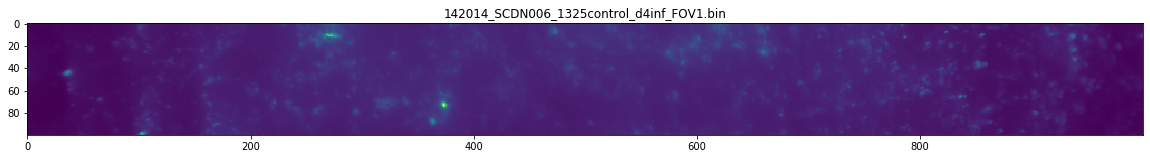

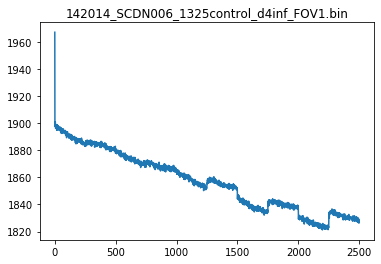

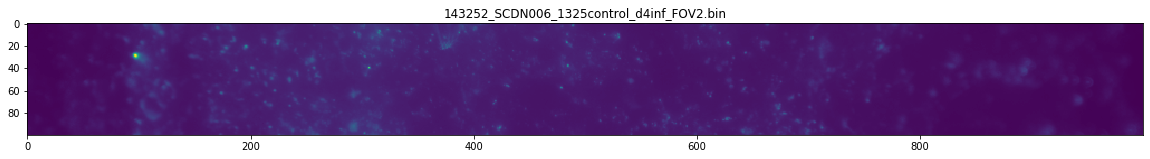

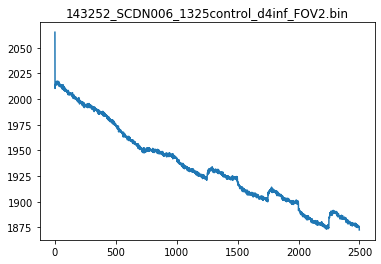

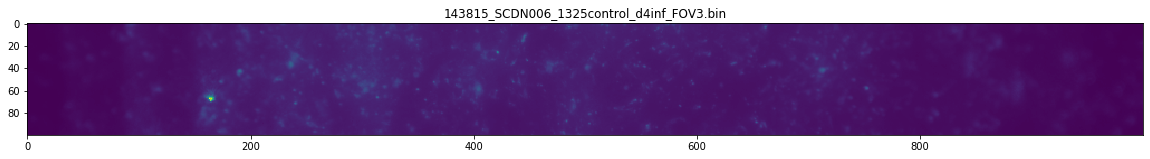

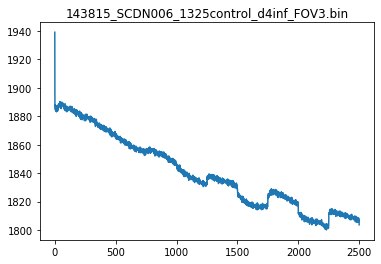

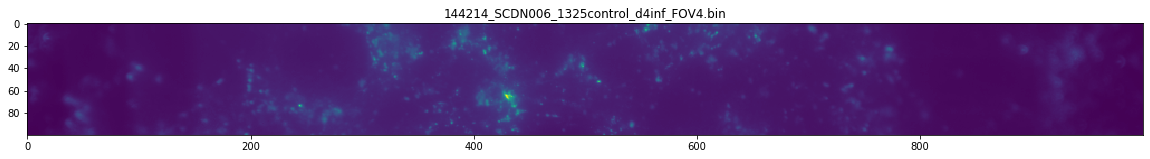

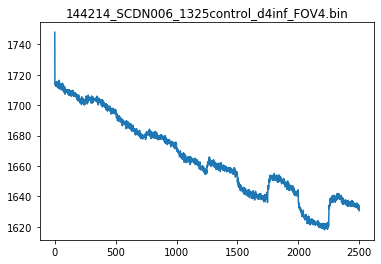

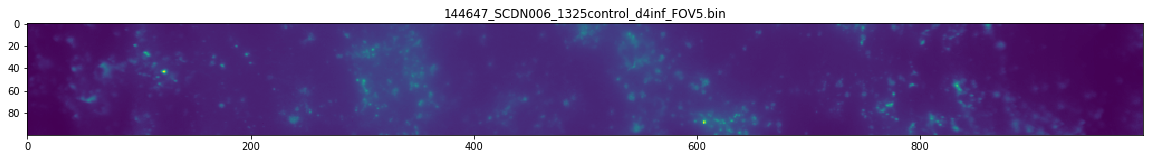

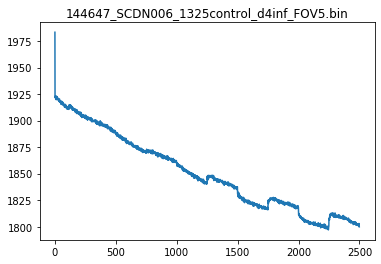

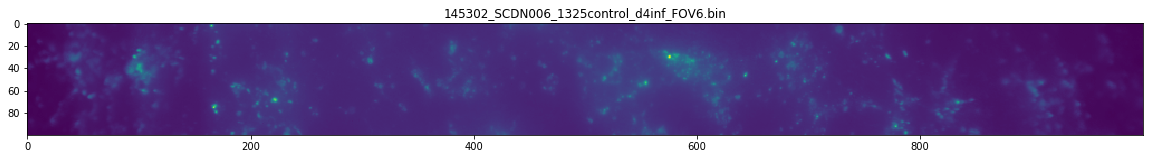

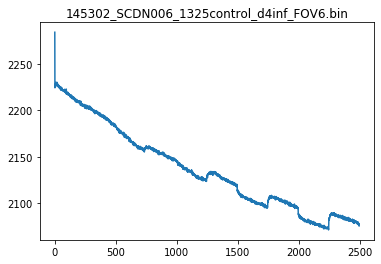

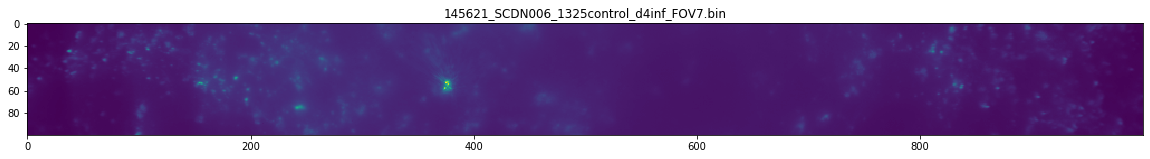

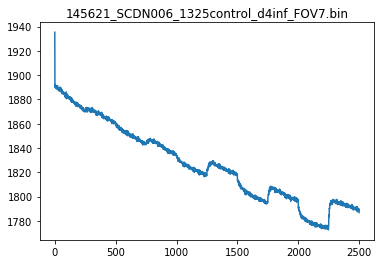

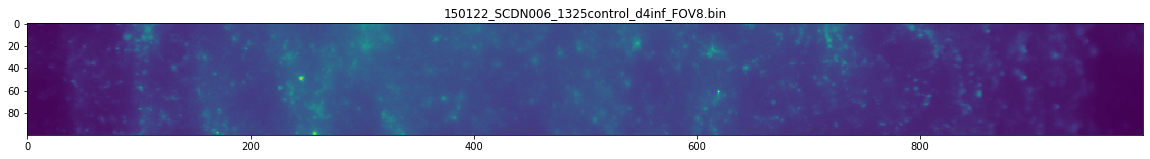

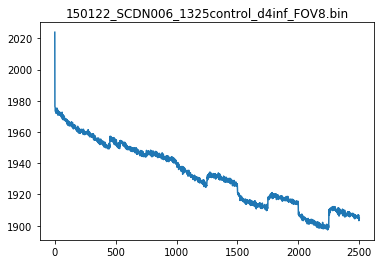

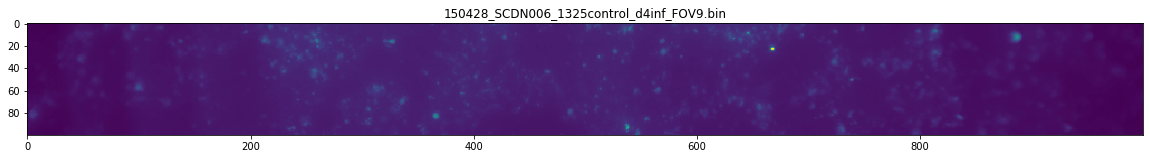

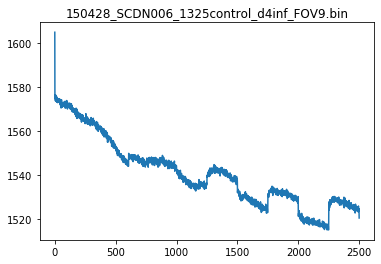

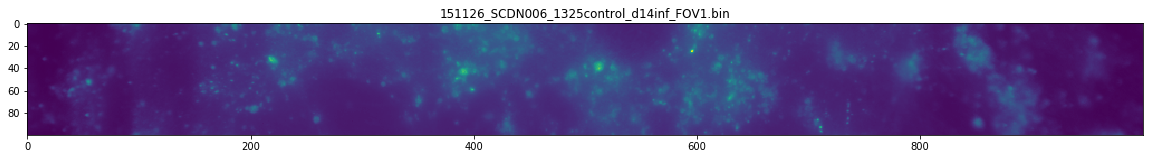

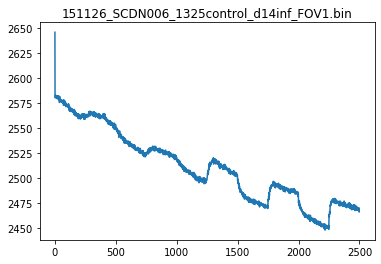

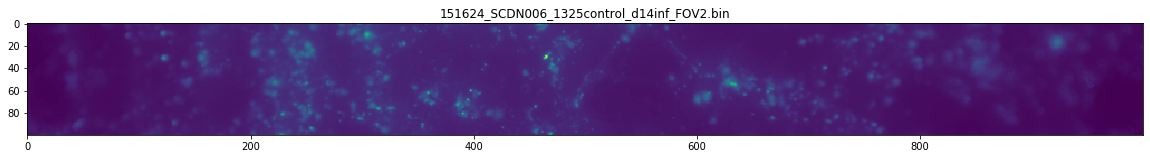

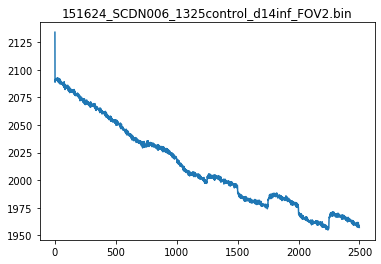

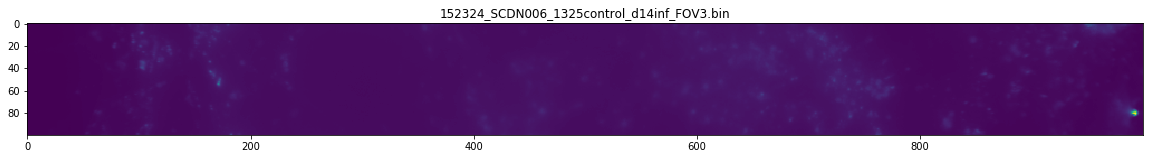

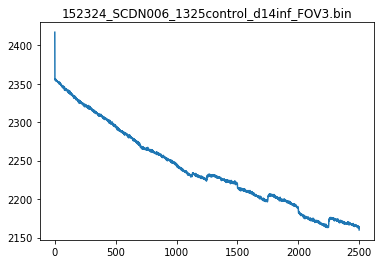

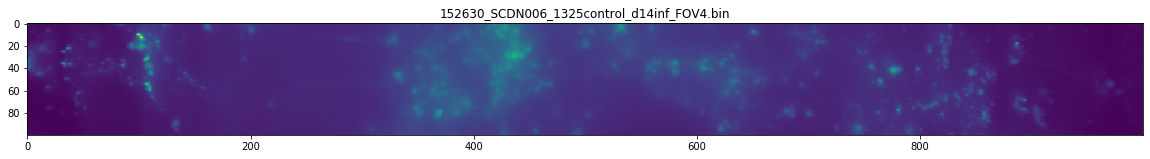

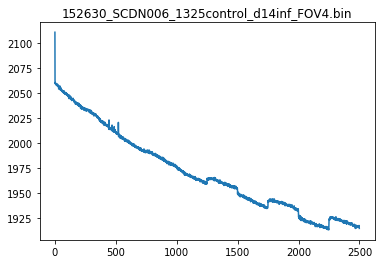

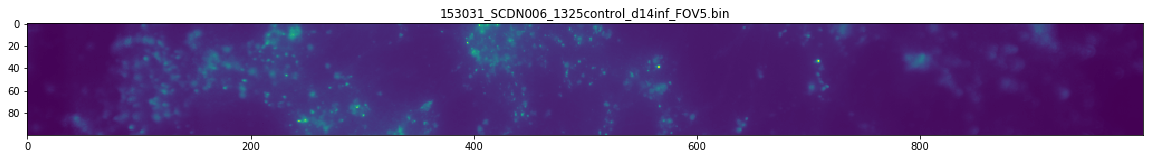

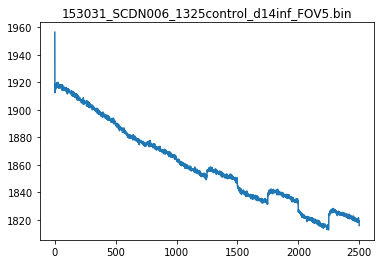

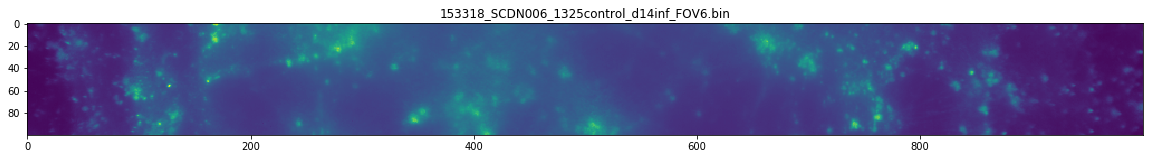

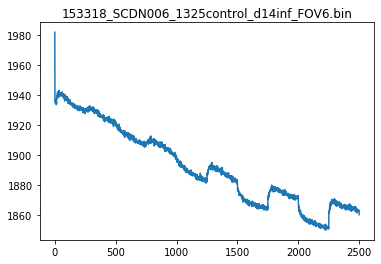

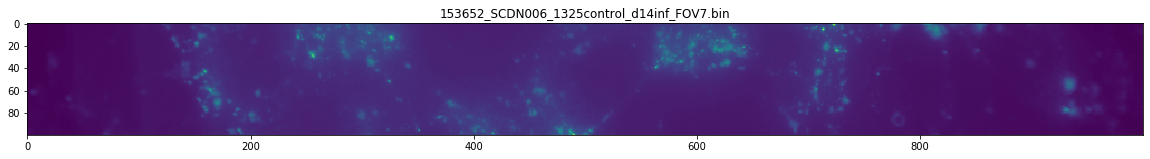

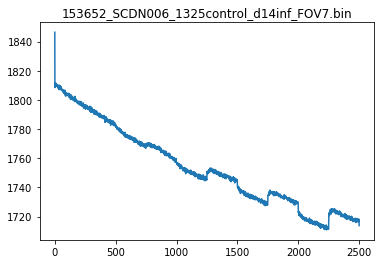

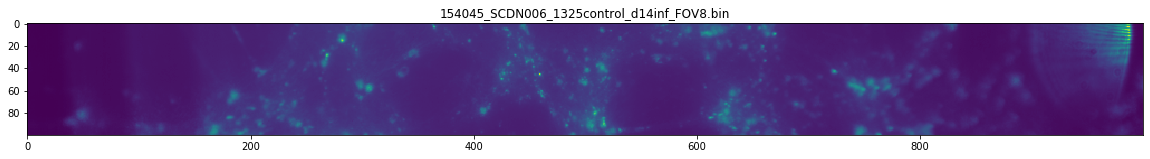

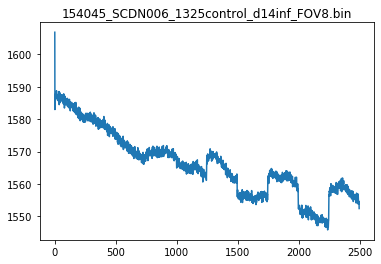

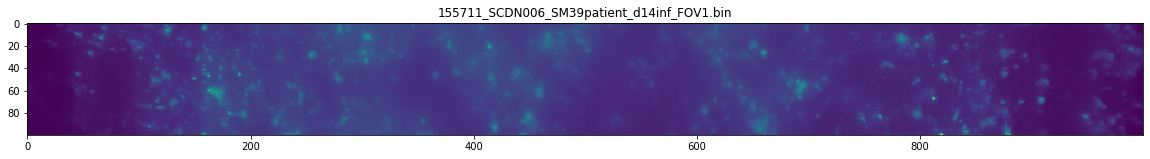

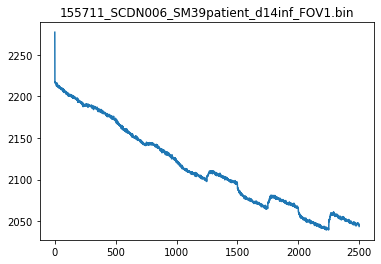

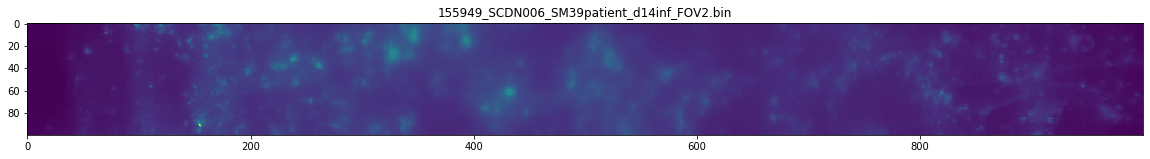

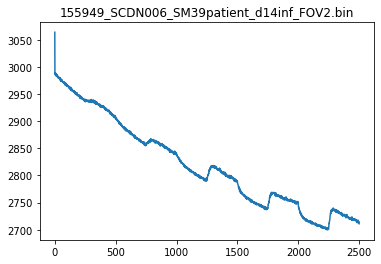

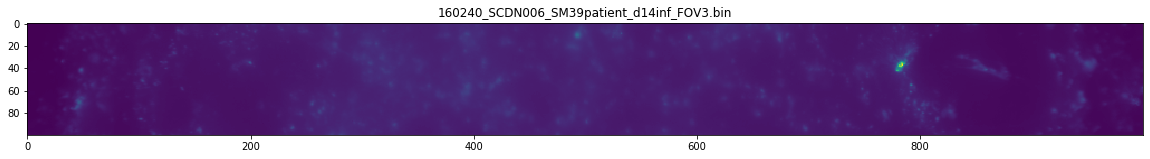

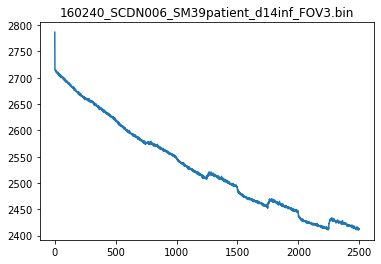

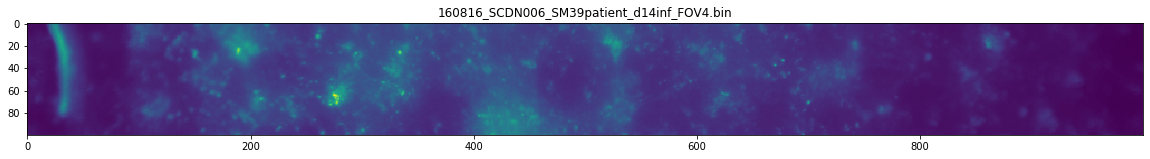

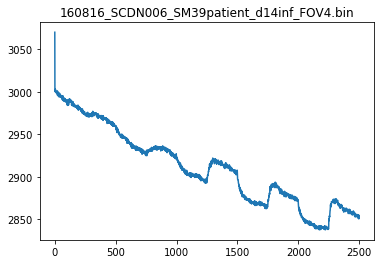

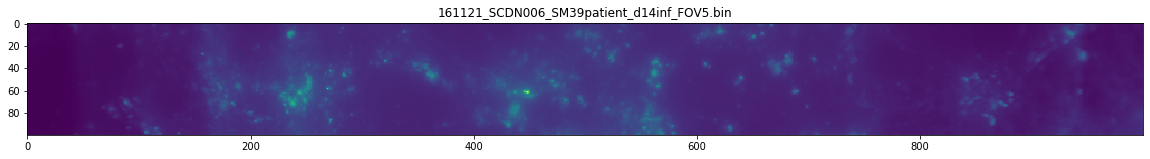

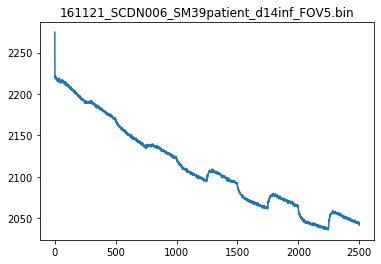

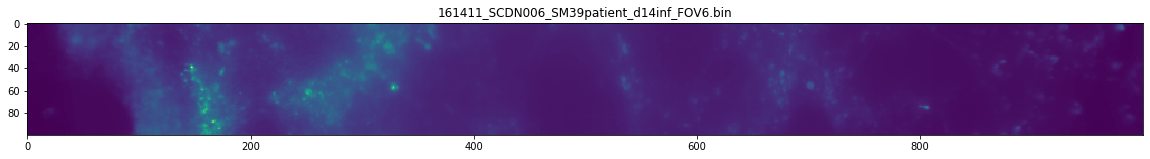

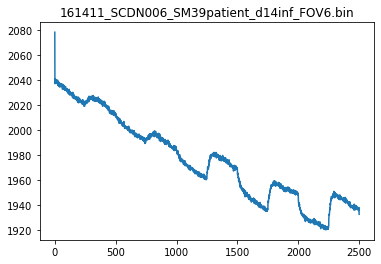

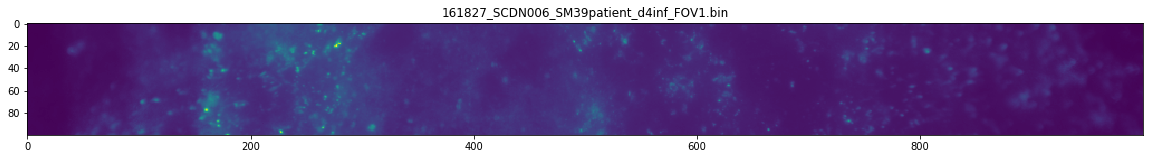

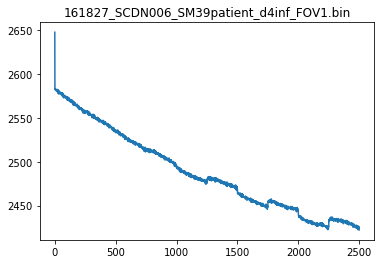

KeyboardInterrupt: 

In [7]:
for file in bin_files:
    filepath = f'{data_folder}/{file}'
    mat = load_file(filepath, size=(-1, 100, 1000), dtype=np.uint16, device=torch.device('cuda'))
    imshow(mat.mean(0), show_colorbar=False, title=file)
    plt.plot(mat.mean(-1).mean(-1).cpu())
    plt.title(file)
    plt.show()
[l for l in log if re.search('FOV8', l[0]) and re.search('1325control', l[0]) and re.search('d14inf', l[0])]

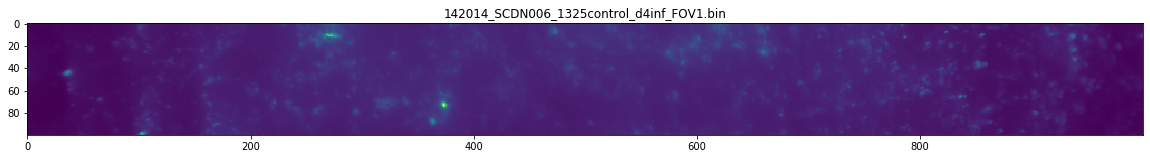

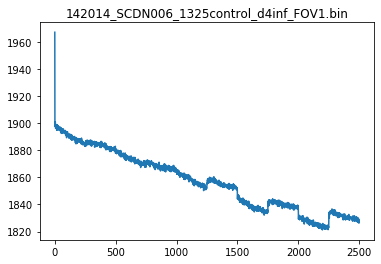

In [9]:
file = bin_files[0]
filepath = f'{data_folder}/{file}'
mat = load_file(filepath, size=(-1, 100, 1000), dtype=np.uint16, device=torch.device('cuda'))
imshow(mat.mean(0), show_colorbar=False, title=file)
plt.plot(mat.mean(-1).mean(-1).cpu())
plt.title(file)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(mat.mean(-1).mean(-1).cpu(), 'r-')
plt.show()

In [ ]:
def get_train_idx(segments):
    train_idx = []
    for seg in segments:
        train_idx += list(range(seg[0], seg[1]))
    return train_idx
train_idx = get_train_idx(segments=[(0, 40), (115, 130)]) # [(20, 70), (150, 180), (250, 300), (390, 420), (520, 550)]
mat_adj, trend = detrend_linear(mat, train_idx=train_idx, return_trend=True)

plt.figure(figsize=(15, 10))
plt.plot(mat.mean(-1).mean(-1).cpu(), 'r-')
plt.plot(trend.mean(-1).mean(-1).cpu(), 'b-')
plt.title(file)
plt.show()

In [ ]:
cor_map = neighbor_cor(mat=mat, neighbors=8, choice='mean', nonnegative=True)
label_image, regions = get_label_image(cor_map, min_pixels=50)
submats, traces = extract_traces(mat, softmask=cor_map, label_image=label_image, regions=regions, percentile=50)

In [38]:
label_image, regions = refine_segmentation(submats, regions, label_image, min_pixels=50)
submats, traces = extract_traces(mat, softmask=cor_map, label_image=label_image, regions=regions, percentile=50)

In [ ]:
imshow(cor_map)
plot_image_label_overlay(cor_map, label_image=label_image, regions=regions)

In [ ]:
for j, trace in enumerate(traces):
    plot_image_label_overlay(cor_map, label_image=label_image, regions=regions, sel_idx=j, figsize=(15, 10))
    plt.figure(figsize=(15, 10))
    trace2 = denoise_trace(trace)
    plt.plot(trace.cpu() + j*200, '-.', c='r', label='raw')
    plt.plot(trace2.cpu() + j*200, '-', c='b', label='denoised')
    plt.legend()
    plt.title(j+1)
    plt.show()

In [ ]:
filepath = '/home/jupyter/voltage/2019-09-24_VoltageMovies/20190924_155117_FOV9.bin'
mat = load_file(filepath, size=(4000, 200, 2000))
mat = mat[100:, :, 600:1200]